In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



In [2]:

# Define the image limit
BATCH_SIZE = 64
TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 10 * BATCH_SIZE
LOSS_EVERY = 5
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=0
LEARNING_RATE = .00001

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

class CachedImageNet(ImageNet):

    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path) or random() < .01:
            # Image transformations
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(imgnet_input)
            hook.remove()
            assert features is not None
            features = features.squeeze(0)
            if os.path.exists(cache_path):
                saved_features = torch.load(cache_path).to(device)
                assert torch.equal(features,saved_features)

            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='0.9'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train loader contains 500 batches.
Test loader contains 10 batches.


torch.Size([64, 1, 224, 224])


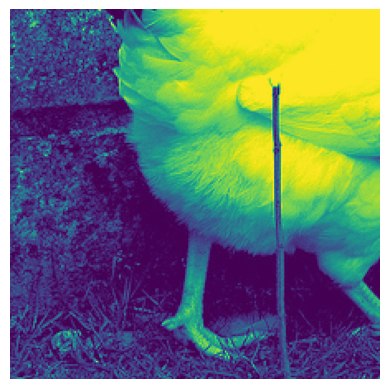

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [5]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 5, LR: 0.000010, Loss: 0.9332


Epoch 1, Batch 10, LR: 0.000010, Loss: 0.8489


Epoch 1, Batch 15, LR: 0.000010, Loss: 0.7760


Epoch 1, Batch 20, LR: 0.000010, Loss: 0.7357


Epoch 1, Batch 25, LR: 0.000010, Loss: 0.7055


Epoch 1, Batch 30, LR: 0.000010, Loss: 0.6860


Epoch 1, Batch 35, LR: 0.000010, Loss: 0.6531


Epoch 1, Batch 40, LR: 0.000010, Loss: 0.6505


Epoch 1, Batch 45, LR: 0.000010, Loss: 0.6476


Epoch 1, Batch 50, LR: 0.000010, Loss: 0.6286


Epoch 1, Batch 55, LR: 0.000010, Loss: 0.6273


Epoch 1, Batch 60, LR: 0.000010, Loss: 0.6253


Epoch 1, Batch 65, LR: 0.000010, Loss: 0.6163


Epoch 1, Batch 70, LR: 0.000010, Loss: 0.6037


Epoch 1, Batch 75, LR: 0.000009, Loss: 0.6110


Epoch 1, Batch 80, LR: 0.000009, Loss: 0.6071


Epoch 1, Batch 85, LR: 0.000009, Loss: 0.6057


Epoch 1, Batch 90, LR: 0.000009, Loss: 0.5903


Epoch 1, Batch 95, LR: 0.000009, Loss: 0.6011


Epoch 1, Batch 100, LR: 0.000009, Loss: 0.5890


Epoch 1, Batch 105, LR: 0.000009, Loss: 0.5948


Epoch 1, Batch 110, LR: 0.000009, Loss: 0.5969


Epoch 1, Batch 115, LR: 0.000009, Loss: 0.5853


Epoch 1, Batch 120, LR: 0.000009, Loss: 0.5944


Epoch 1, Batch 125, LR: 0.000009, Loss: 0.5988


Epoch 1, Batch 130, LR: 0.000008, Loss: 0.5960


Epoch 1, Batch 135, LR: 0.000008, Loss: 0.5923


Epoch 1, Batch 140, LR: 0.000008, Loss: 0.5887


Epoch 1, Batch 145, LR: 0.000008, Loss: 0.5901


Epoch 1, Batch 150, LR: 0.000008, Loss: 0.5928


Epoch 1, Batch 155, LR: 0.000008, Loss: 0.5886


Epoch 1, Batch 160, LR: 0.000008, Loss: 0.5931


Epoch 1, Batch 165, LR: 0.000008, Loss: 0.5932


Epoch 1, Batch 170, LR: 0.000007, Loss: 0.5852


Epoch 1, Batch 175, LR: 0.000007, Loss: 0.5914


Epoch 1, Batch 180, LR: 0.000007, Loss: 0.5888


Epoch 1, Batch 185, LR: 0.000007, Loss: 0.5905


Epoch 1, Batch 190, LR: 0.000007, Loss: 0.5820


Epoch 1, Batch 195, LR: 0.000007, Loss: 0.5871


Epoch 1, Batch 200, LR: 0.000007, Loss: 0.5811


Epoch 1, Batch 205, LR: 0.000006, Loss: 0.5868


Epoch 1, Batch 210, LR: 0.000006, Loss: 0.5866


Epoch 1, Batch 215, LR: 0.000006, Loss: 0.5858


Epoch 1, Batch 220, LR: 0.000006, Loss: 0.5838


Epoch 1, Batch 225, LR: 0.000006, Loss: 0.5853


Epoch 1, Batch 230, LR: 0.000006, Loss: 0.5875


Epoch 1, Batch 235, LR: 0.000005, Loss: 0.5908


Epoch 1, Batch 240, LR: 0.000005, Loss: 0.5836


Epoch 1, Batch 245, LR: 0.000005, Loss: 0.5805


Epoch 1, Batch 250, LR: 0.000005, Loss: 0.5697


Epoch 1, Batch 255, LR: 0.000005, Loss: 0.5836


Epoch 1, Batch 260, LR: 0.000005, Loss: 0.5805


Epoch 1, Batch 265, LR: 0.000005, Loss: 0.5827


Epoch 1, Batch 270, LR: 0.000004, Loss: 0.5794


Epoch 1, Batch 275, LR: 0.000004, Loss: 0.5838


Epoch 1, Batch 280, LR: 0.000004, Loss: 0.5812


Epoch 1, Batch 285, LR: 0.000004, Loss: 0.5807


Epoch 1, Batch 290, LR: 0.000004, Loss: 0.5815


Epoch 1, Batch 295, LR: 0.000004, Loss: 0.5839


Epoch 1, Batch 300, LR: 0.000003, Loss: 0.5861


Epoch 1, Batch 305, LR: 0.000003, Loss: 0.5770


Epoch 1, Batch 310, LR: 0.000003, Loss: 0.5841


Epoch 1, Batch 315, LR: 0.000003, Loss: 0.5839


Epoch 1, Batch 320, LR: 0.000003, Loss: 0.5826


Epoch 1, Batch 325, LR: 0.000003, Loss: 0.5906


Epoch 1, Batch 330, LR: 0.000003, Loss: 0.5797


Epoch 1, Batch 335, LR: 0.000002, Loss: 0.5800


Epoch 1, Batch 340, LR: 0.000002, Loss: 0.5840


Epoch 1, Batch 345, LR: 0.000002, Loss: 0.5868


Epoch 1, Batch 350, LR: 0.000002, Loss: 0.5859


Epoch 1, Batch 355, LR: 0.000002, Loss: 0.5790


Epoch 1, Batch 360, LR: 0.000002, Loss: 0.5852


Epoch 1, Batch 365, LR: 0.000002, Loss: 0.5836


Epoch 1, Batch 370, LR: 0.000002, Loss: 0.5755


Epoch 1, Batch 375, LR: 0.000001, Loss: 0.5805


Epoch 1, Batch 380, LR: 0.000001, Loss: 0.5822


Epoch 1, Batch 385, LR: 0.000001, Loss: 0.5852


Epoch 1, Batch 390, LR: 0.000001, Loss: 0.5870


Epoch 1, Batch 395, LR: 0.000001, Loss: 0.5830


Epoch 1, Batch 400, LR: 0.000001, Loss: 0.5808


Epoch 1, Batch 405, LR: 0.000001, Loss: 0.5828


Epoch 1, Batch 410, LR: 0.000001, Loss: 0.5804


Epoch 1, Batch 415, LR: 0.000001, Loss: 0.5791


Epoch 1, Batch 420, LR: 0.000001, Loss: 0.5827


Epoch 1, Batch 425, LR: 0.000001, Loss: 0.5865


Epoch 1, Batch 430, LR: 0.000000, Loss: 0.5858


Epoch 1, Batch 435, LR: 0.000000, Loss: 0.5789


Epoch 1, Batch 440, LR: 0.000000, Loss: 0.5892


Epoch 1, Batch 445, LR: 0.000000, Loss: 0.5753


Epoch 1, Batch 450, LR: 0.000000, Loss: 0.5786


Epoch 1, Batch 455, LR: 0.000000, Loss: 0.5752


Epoch 1, Batch 460, LR: 0.000000, Loss: 0.5785


Epoch 1, Batch 465, LR: 0.000000, Loss: 0.5831


Epoch 1, Batch 470, LR: 0.000000, Loss: 0.5782


Epoch 1, Batch 475, LR: 0.000000, Loss: 0.5789


Epoch 1, Batch 480, LR: 0.000000, Loss: 0.5780


Epoch 1, Batch 485, LR: 0.000000, Loss: 0.5831


Epoch 1, Batch 490, LR: 0.000000, Loss: 0.5804


Epoch 1, Batch 495, LR: 0.000000, Loss: 0.5853


Epoch 1, Batch 500, LR: 0.000000, Loss: 0.5811


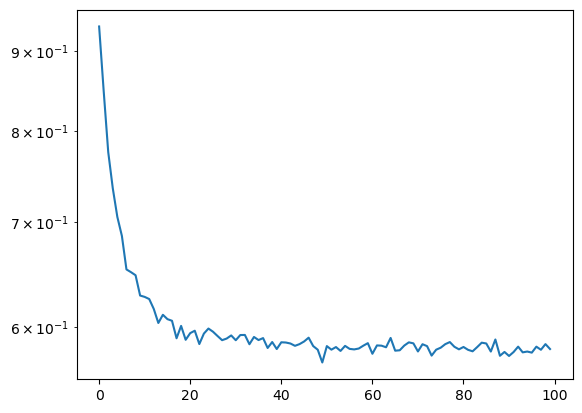

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:09,  1.03s/it]

 20%|██        | 2/10 [00:02<00:08,  1.00s/it]

 30%|███       | 3/10 [00:03<00:07,  1.00s/it]

 40%|████      | 4/10 [00:03<00:05,  1.02it/s]

 50%|█████     | 5/10 [00:04<00:04,  1.01it/s]

 60%|██████    | 6/10 [00:06<00:04,  1.01s/it]

 70%|███████   | 7/10 [00:07<00:03,  1.00s/it]

 80%|████████  | 8/10 [00:08<00:02,  1.07s/it]

 90%|█████████ | 9/10 [00:09<00:01,  1.05s/it]

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]

Test Loss: 0.5832


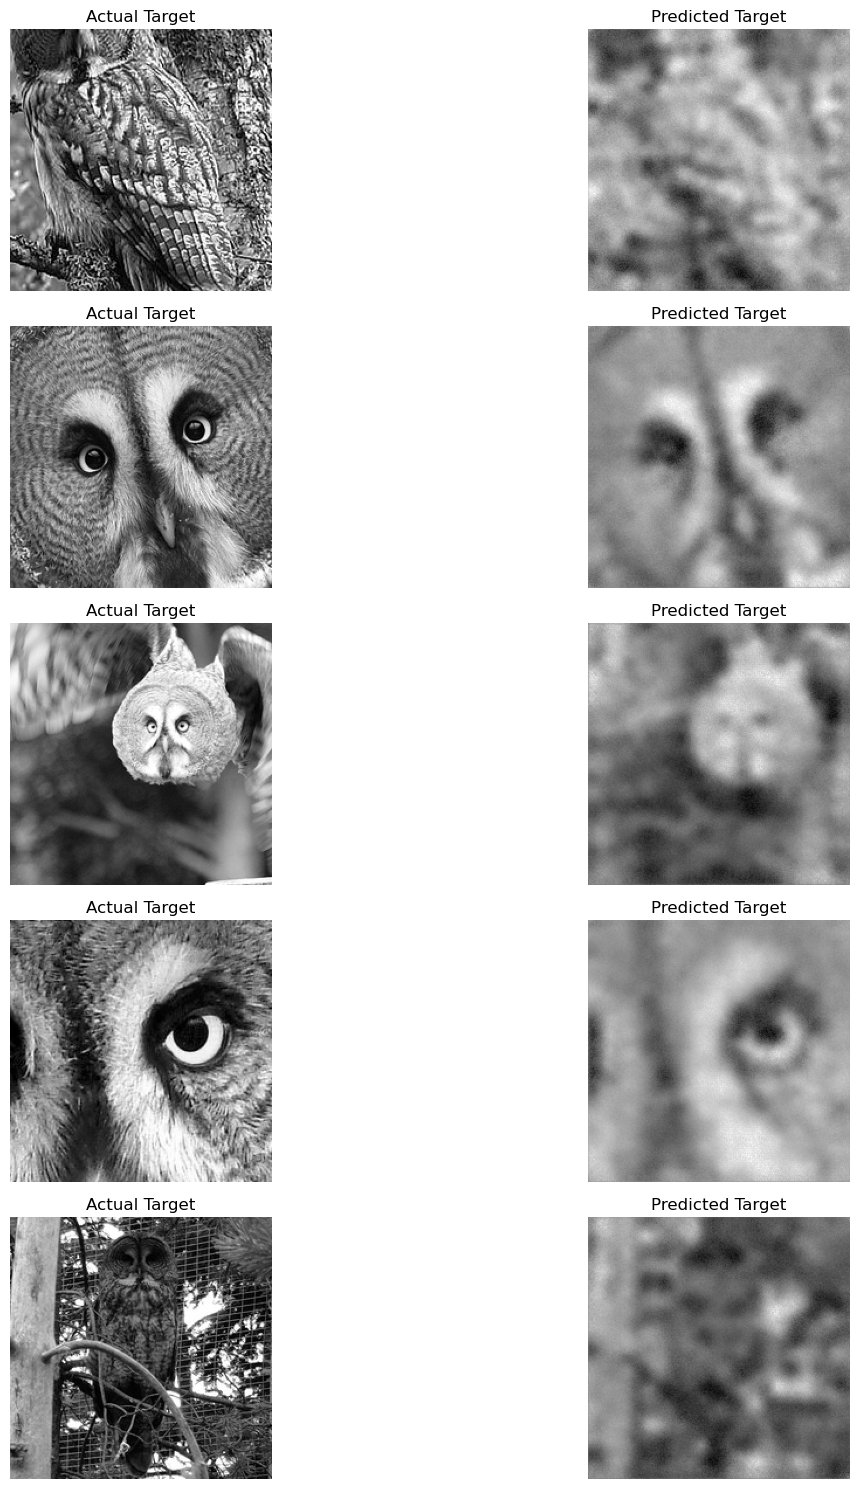

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-10.7092) tensor(4.5909)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
torch.save(model, join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt"))